In [1]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
# I have loaded the Titanic dataset from a CSV file.
data = pd.read_csv('/content/train.csv')

In [3]:
# I have handled missing values in the dataset to ensure all features are complete.
imputer = SimpleImputer(strategy='mean')
data['Age'] = imputer.fit_transform(data[['Age']])
data['Fare'] = imputer.fit_transform(data[['Fare']])
data['Embarked'].fillna('S', inplace=True)

<ipython-input-3-5dcfb378549e>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Embarked'].fillna('S', inplace=True)


In [5]:
# I have encoded the categorical variables ('Sex' and 'Embarked') into numeric values using LabelEncoder.
label_encoders = {}
for col in ['Sex', 'Embarked']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

In [6]:
# I have prepared the features (X) and target (y) for model training.
X = data.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
y = data['Survived']

In [7]:
# I have split the dataset into training and validation sets to evaluate the model's performance.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# I have converted the datasets into DMatrix format, which is optimized for XGBoost computations.
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [9]:
# I have defined a learning rate decay function to reduce the learning rate exponentially over boosting rounds.
def learning_rate_decay(iteration):
    initial_lr = 0.1  # I have set the initial learning rate to 0.1.
    decay_rate = 0.99  # I have chosen a decay rate of 0.99 to gradually reduce the learning rate.
    return initial_lr * (decay_rate ** iteration)  # Exponential decay formula

In [10]:
# I have created a callback to apply the learning rate decay during training.
# This callback dynamically adjusts the learning rate after each boosting round.
callback = xgb.callback.LearningRateScheduler(learning_rate_decay)

In [11]:
# I have defined the hyperparameters for the XGBoost model.
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'eta': 0.1  # Initial learning rate (will be overridden by the callback)
}

In [12]:
# I have trained the XGBoost model with learning rate decay.
# The callback reduces the learning rate after each iteration to improve convergence.
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dval, 'validation')],
    callbacks=[callback],  # Apply the learning rate decay callback
    early_stopping_rounds=10
)

[0]	validation-logloss:0.63257
[1]	validation-logloss:0.59429
[2]	validation-logloss:0.56316
[3]	validation-logloss:0.53869
[4]	validation-logloss:0.52044
[5]	validation-logloss:0.50355
[6]	validation-logloss:0.48984
[7]	validation-logloss:0.47851
[8]	validation-logloss:0.46892
[9]	validation-logloss:0.46124
[10]	validation-logloss:0.45563
[11]	validation-logloss:0.44855
[12]	validation-logloss:0.44192
[13]	validation-logloss:0.43872
[14]	validation-logloss:0.43508
[15]	validation-logloss:0.43152
[16]	validation-logloss:0.42988
[17]	validation-logloss:0.42801
[18]	validation-logloss:0.42696
[19]	validation-logloss:0.42510
[20]	validation-logloss:0.42313
[21]	validation-logloss:0.42121
[22]	validation-logloss:0.41994
[23]	validation-logloss:0.41912
[24]	validation-logloss:0.41858
[25]	validation-logloss:0.41755
[26]	validation-logloss:0.41814
[27]	validation-logloss:0.41751
[28]	validation-logloss:0.41665
[29]	validation-logloss:0.41744
[30]	validation-logloss:0.41732
[31]	validation-lo

In [13]:
# I have made predictions on the validation set using the trained XGBoost model.
y_pred_prob = bst.predict(dval)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

In [14]:
# I have evaluated the model's performance using accuracy.
print("Accuracy:", accuracy_score(y_val, y_pred))

Accuracy: 0.8268156424581006


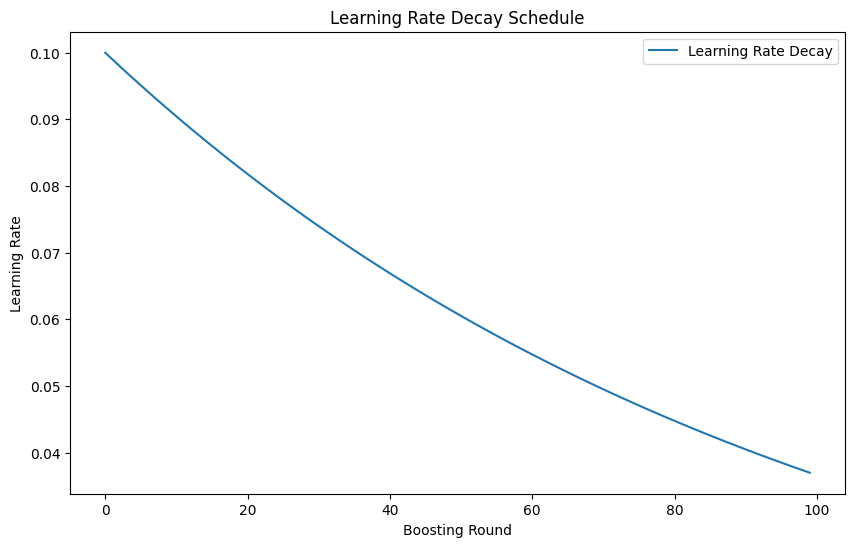

In [15]:
# I have visualized the learning rate decay over boosting rounds to confirm the schedule.
# This plot shows how the learning rate decreases exponentially with each iteration.
plt.figure(figsize=(10, 6))
plt.plot([learning_rate_decay(i) for i in range(100)], label='Learning Rate Decay')
plt.xlabel("Boosting Round")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Decay Schedule")
plt.legend()
plt.show()